In [ ]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_dataloaders(dataset_dir, input_size, batch_size, num_workers=4):
    """
    Get train and test dataloaders from the dataset
    """
    def read_pil_image(img_path, height, width): 
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

    def load_all_images(dataset_path, height, width, img_ext='jpg'):
        return np.array([read_pil_image(str(p), height, width) for p in 
                                        Path(dataset_path).rglob("*."+img_ext)]) 

    # Load the data 
    loaded_imgs_train = load_all_images(dataset_dir+'/train/', input_size, input_size)
    
    #calculate mean and standard deviation per channels
    mean = [(loaded_imgs_train[..., i]/255).mean() for i in range(loaded_imgs_train.shape[-1])]
    #print(mean)
    std = [(loaded_imgs_train[..., i]/255).std() for i in range(loaded_imgs_train.shape[-1])]
    #print(std)
    
    #data transforms for trainig and testing
    train_transform = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=20),
                        #transforms.RandomAffine(translate=(0, 0.3)),
                        transforms.Resize((input_size, input_size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean = mean, std = std)])

    test_transform = transforms.Compose([
                        transforms.Resize((input_size, input_size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean = mean, std = std)])    


     # prepare datasets
    train_data = datasets.ImageFolder(dataset_dir+'train', transform = train_transform)
    test_data = datasets.ImageFolder(dataset_dir+'test', transform = test_transform)

    # prepare dataloaders
    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader




In [ ]:
def accuracy(output, target):
  pred = output.argmax(dim=1)  # get the index of the max log-probability
  return (pred == target).sum().item() / target.numel()  #return the mean accuracy in the batch


In [ ]:
def eval_epoch(model, test_loader, criterion, epoch):  #evaluation function after one epoch of training
  
    model.eval()     #eval mode
      
    with torch.no_grad():
        eval_losses = []
        eval_accs = []
        for (inputs, labels) in test_loader:
            #send to GPU device
            inputs, labels = inputs.to(device), labels.to(device)            
            #forward pass
            outputs = model(inputs)  
            #compute the loss in the batch
            eval_loss = criterion(outputs, labels)
            eval_losses.append(eval_loss.item()) #save loss value
            #compute the accuracy in the batch
            eval_acc = 100 * accuracy(outputs, labels) 
            eval_accs.append(eval_acc) #save the accuracy value 
            
        print('Val Epoch: {} \tAverage loss: {:.4f}\tAverage Acc: {:.2f} %'.format(
            epoch, np.mean(eval_losses), np.mean(eval_accs)))
        
        #val_writer.add_scalar('Loss', np.mean(eval_losses), epoch)  #log validation loss for one epoch to Tensorboard
        #val_writer.add_scalar('Acc',  np.mean(eval_accs), epoch)    #log validation accuracy for one epoch to Tensorboard

    return np.mean(eval_losses), np.mean(eval_accs)    

In [ ]:
DATASETDIR = '/content/drive/My Drive/MIT_split/'
MODEL_FNAME = 'model.h5'
BATCH_SIZE = 32
EPOCHS = 100
INPUT_SIZE = 64


In [ ]:
train_loader, test_loader = get_dataloaders(DATASETDIR, INPUT_SIZE, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self, in_channels=3, kernel_size=3, padding="same"):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1_1 = nn.Conv2d(in_channels, 32, kernel_size, padding=padding)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size, padding=padding)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.bn1_2 = nn.BatchNorm2d(32)
        
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size, padding=padding)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size, padding=padding)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.bn2_2 = nn.BatchNorm2d(64)
        
        self.max_pool = nn.MaxPool2d(2,2)
        
        self.dropout = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten()
    
        self.fc1 = nn.Linear(64, 8)
        
        #self.logmax = nn.LogSoftmax(dim=1)216, 128)

    def forward(self, x):
        ## Define forward behavior
        x = self.conv1_1(x)
        x = F.elu(self.bn1_1(x))
        x = self.conv1_2(x)
        x = F.elu(self.bn1_2(x))
        x = self.max_pool(x)

        x = self.conv2_1(x)
        x = F.elu(self.bn2_1(x))
        x = self.conv2_2(x)
        x = F.elu(self.bn2_2(x))
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.global_avg_pool(x)
        x = self.flat(x)


        #x = x.view(-1, 64)

        x = self.fc1(x)
        
        return x

    def get_embedding(self, x):
        return self.forward(x)

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 256
"""
dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=256)"""

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200


### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###
criterion = nn.CrossEntropyLoss()   #logsoftmax layer + NLLLoss

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    #test(dataset1, dataset2, model, accuracy_calculator)
    val_loss, val_acc = eval_epoch(model, test_loader, criterion, epoch)  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Iteration 0: Loss = 0.10462222993373871, Number of mined triplets = 665
Epoch 1 Iteration 20: Loss = 0.10958874225616455, Number of mined triplets = 407
Epoch 1 Iteration 40: Loss = 0.1010066419839859, Number of mined triplets = 340
Val Epoch: 1 	Average loss: 3.5688	Average Acc: 9.68 %
Epoch 2 Iteration 0: Loss = 0.11023373901844025, Number of mined triplets = 342
Epoch 2 Iteration 20: Loss = 0.10280798375606537, Number of mined triplets = 351
Epoch 2 Iteration 40: Loss = 0.10423138737678528, Number of mined triplets = 295
Val Epoch: 2 	Average loss: 3.4593	Average Acc: 9.68 %
Epoch 3 Iteration 0: Loss = 0.10492511838674545, Number of mined triplets = 397
Epoch 3 Iteration 20: Loss = 0.0932520404458046, Number of mined triplets = 296
Epoch 3 Iteration 40: Loss = 0.0996924638748169, Number of mined triplets = 384
Val Epoch: 3 	Average loss: 3.6339	Average Acc: 12.33 %
Epoch 4 Iteration 0: Loss = 0.09898703545331955, Number of mined triplets = 314
Epoch 4 Iteration 20: Loss = 0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


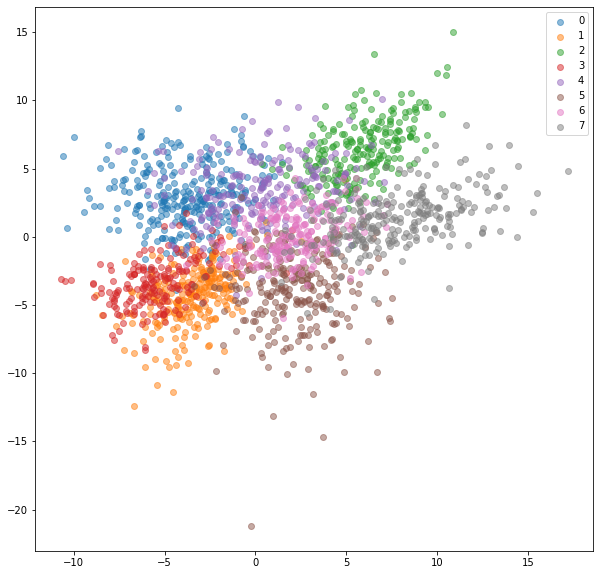

In [ ]:
%matplotlib inline
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 8))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images.float()).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
#val_embeddings_otl, val_labels_otl = extract_embeddings(siamese_test_dataset, model)
#plot_embeddings(val_embeddings_otl, val_labels_otl)